In [67]:
# Assignment 20

# Time Series Analysis : ARIMA

In [68]:
import pandas as pd

df = pd.read_csv('exchange_rate.csv')

df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [69]:
print(df.shape)

df.info()

(7588, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [70]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [71]:
# checking for missing values

df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [72]:
# checking for duplicates

df.duplicated().sum()

0

In [73]:
# parsing 'date' to datetime type

df['date'] = pd.to_datetime(df['date'],format = '%d-%m-%Y %H:%M')

In [74]:
df['date'].head()

0   1990-01-01
1   1990-01-02
2   1990-01-03
3   1990-01-04
4   1990-01-05
Name: date, dtype: datetime64[ns]

In [75]:
df['date'].tail()

7583   2010-10-06
7584   2010-10-07
7585   2010-10-08
7586   2010-10-09
7587   2010-10-10
Name: date, dtype: datetime64[ns]

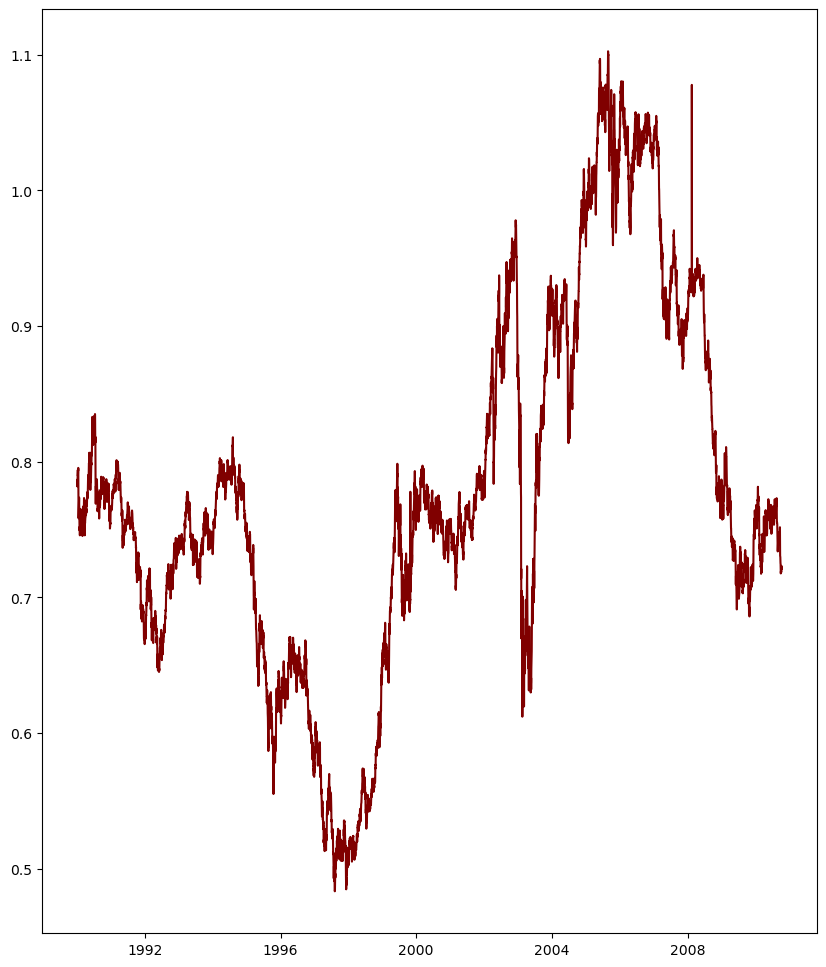

In [76]:
# plotting the time series for currency
import matplotlib.pyplot as plt

plt.figure(figsize=(10,12))
plt.plot(df['date'], df['Ex_rate'], color='maroon')
plt.show()

In [77]:
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

In [78]:
# determining 'd'
series = df['Ex_rate']

def determine_d(series, max_d=3):
    d = 0
    current_series = series.dropna()
    result = adfuller(current_series)
    print(f"ADF p-value (d={d}): {result[1]}")

    while result[1] > 0.05 and d < max_d:
        d += 1
        current_series = current_series.diff().dropna()
        result = adfuller(current_series)
        print(f"ADF p-value (d={d}): {result[1]}")

    return d, current_series

d_value, differenced_series = determine_d(series)

ADF p-value (d=0): 0.4492327353597479
ADF p-value (d=1): 0.0


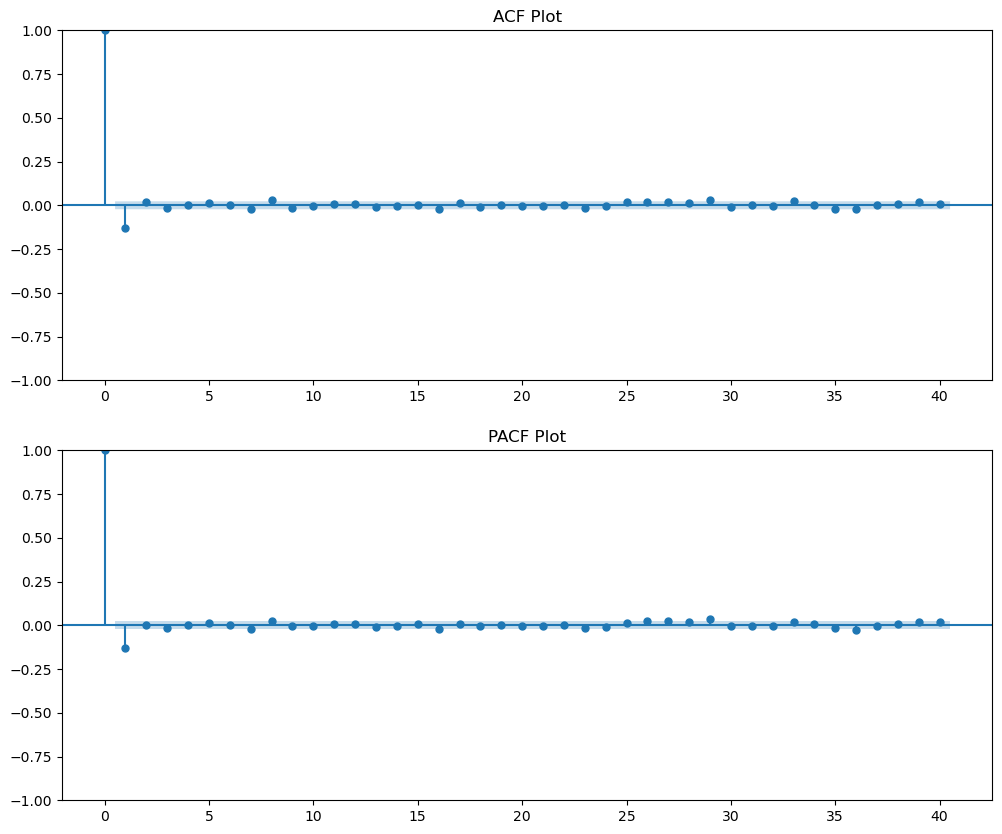

In [79]:
# ploting ACF and PACF to determine 'p' and 'q'
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(differenced_series, ax=ax1, lags=40, title='ACF Plot')
plot_pacf(differenced_series, ax=ax2, lags=40, title='PACF Plot')
plt.show()

In [80]:
# model building
from statsmodels.tsa.arima.model import ARIMA

d,p,q = 1,1,1

model = ARIMA(df['Ex_rate'], order=(p, d, q))
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Tue, 16 Sep 2025   AIC                         -56102.322
Time:                        00:09:18   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.000    3.58e-05    3.62e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2865078.33
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        98.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

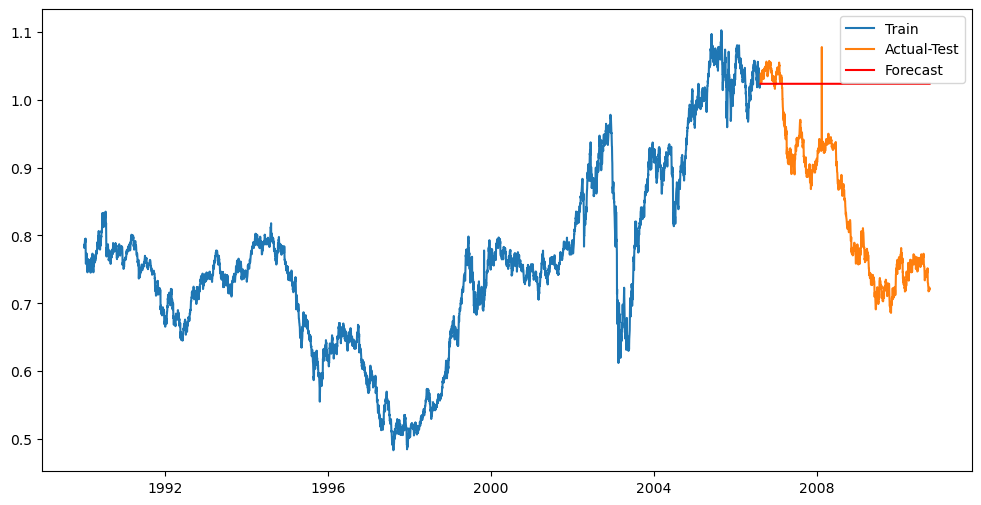

In [81]:
import numpy as np

# train-test split
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))

forecast_series = pd.Series(forecast, index=test.index)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Actual-Test")
plt.plot(forecast_series, label="Forecast", color="red")
plt.legend()

In [82]:
# evaluation

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, forecast_series)
rmse = np.sqrt(mean_squared_error(test, forecast_series))

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

MAE: 0.178
RMSE: 0.205


In [83]:
# exponential Smoothing

from statsmodels.tsa.holtwinters import ExponentialSmoothing

seasonal_periods = 365  
hw_model = ExponentialSmoothing(train, trend='add', seasonal='add',seasonal_periods=seasonal_periods)

hw_fit = hw_model.fit(optimized=True)

hw_forecast = hw_fit.forecast(steps=len(test))

hw_forecast = pd.Series(hw_forecast, index=test.index)

In [84]:
# evaluating 

mae = mean_absolute_error(test, hw_forecast)
rmse = np.sqrt(mean_squared_error(test, hw_forecast))
mape = np.mean(np.abs((test.values - hw_forecast.values) / test.values)) * 100

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mape:.3f}")

MAE: 0.194
RMSE: 0.223
MAE: 24.835


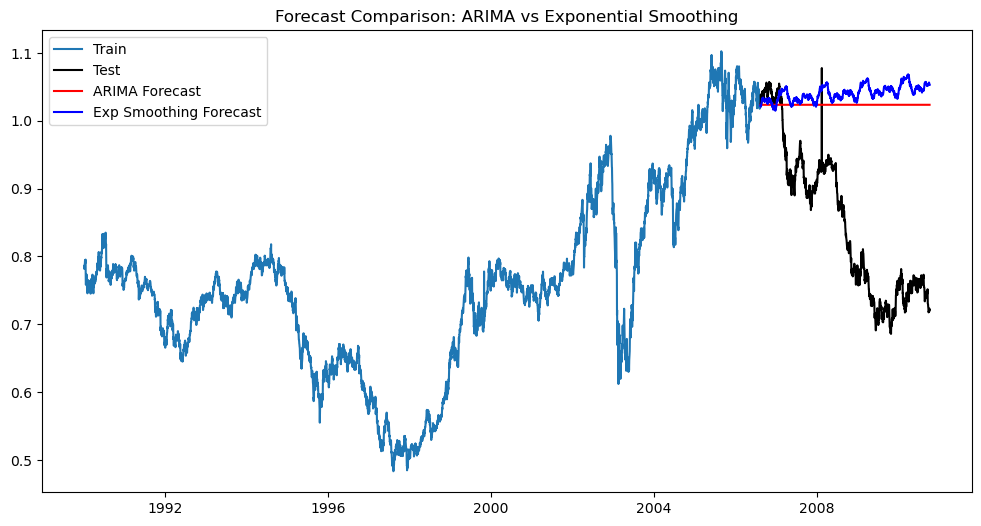

In [85]:
# visualization

plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='black')
plt.plot(arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(hw_forecast, label='Exp Smoothing Forecast', color='blue')
plt.legend()
plt.title("Forecast Comparison: ARIMA vs Exponential Smoothing")
plt.show()

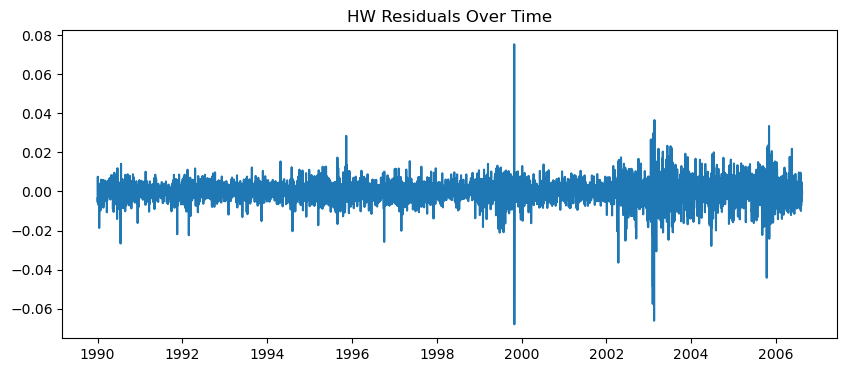

<Figure size 800x400 with 0 Axes>

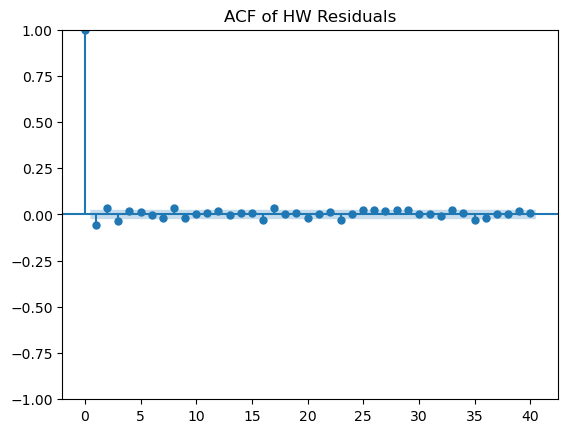

<Figure size 600x600 with 0 Axes>

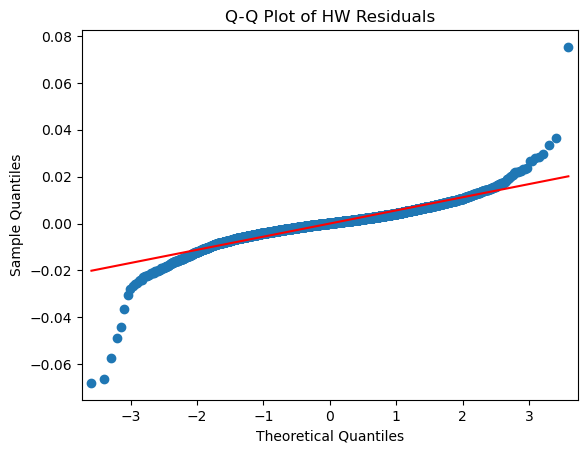

In [86]:
# residual diagnostics for HW

residuals_hw = hw_fit.resid

plt.figure(figsize=(10,4))
plt.plot(residuals_hw)
plt.title("HW Residuals Over Time")
plt.show()

plt.figure(figsize=(8,4))
plot_acf(residuals_hw.dropna(), lags=40)
plt.title("ACF of HW Residuals")
plt.show()

plt.figure(figsize=(6,6))
sm.qqplot(residuals_hw.dropna(), line='s')
plt.title("Q-Q Plot of HW Residuals")
plt.show()